In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA

In [2]:
plt.rcParams.update(
    {
        "axes.grid": True,
        "grid.alpha": 0.5,
        "grid.linestyle": "--"
    }
)


## Import data

In [3]:
df = pd.read_csv("../data/FS_features_ABIDE_males.csv", sep=";")
df = df.set_index("FILE_ID")

# drop target
y = df["AGE_AT_SCAN"]
df = df.drop("AGE_AT_SCAN", axis=1)

print("Number of istances: ", df.shape[0])
print("Number of columns: ", df.shape[1])

Number of istances:  915
Number of columns:  422


In [4]:
df.head()

SEX    FIQ  DX_GROUP  lh_caudalanteriorcingulate_SurfArea  \
FILE_ID                                                                      
Caltech_0051456    1  126.0         1                                  909   
Caltech_0051457    1  107.0         1                                 1425   
Caltech_0051458    1   93.0         1                                 1205   
Caltech_0051459    1  106.0         1                                 1413   
Caltech_0051461    1   99.0         1                                  875   

                 lh_caudalanteriorcingulate_GrayVol  \
FILE_ID                                               
Caltech_0051456                                2684   
Caltech_0051457                                4623   
Caltech_0051458                                3940   
Caltech_0051459                                4711   
Caltech_0051461                                2270   

                 lh_caudalanteriorcingulate_ThickAvg  \
FILE_ID                                                
Caltech_0051456                                2.918   
Caltech_0051457                                3.046   
Caltech_0051458                                2.987   
Caltech_0051459                                2.879   
Caltech_0051461                                2.473   

                 lh_caudalanteriorcingulate_ThickStd  \
FILE_ID                                                
Caltech_0051456                                0.481   
Caltech_0051457                                0.543   
Caltech_0051458                                0.423   
Caltech_0051459                                0.587   
Caltech_0051461                                0.475   

                 lh_caudalanteriorcingulate_MeanCurv  \
FILE_ID                                                
Caltech_0051456                                0.134   
Caltech_0051457                                0.116   
Caltech_0051458                                0.104   
Caltech_0051459                                0.120   
Caltech_0051461                                0.104   

                 lh_caudalanteriorcingulate_CurvInd  \
FILE_ID                                               
Caltech_0051456                                 1.3   
Caltech_0051457                                 2.0   
Caltech_0051458                                 1.4   
Caltech_0051459                                 1.7   
Caltech_0051461                                 0.7   

                 lh_caudalmiddlefrontal_SurfArea  ...  \
FILE_ID                                           ...   
Caltech_0051456                             2655  ...   
Caltech_0051457                             3631  ...   
Caltech_0051458                             2685  ...   
Caltech_0051459                             3203  ...   
Caltech_0051461                             2453  ...   

                 CC_Mid_Anterior_Volume_mm3  CC_Anterior_Volume_mm3  \
FILE_ID                                                               
Caltech_0051456                       788.7                   929.8   
Caltech_0051457                       907.3                  1066.6   
Caltech_0051458                       964.2                  1104.3   
Caltech_0051459                       811.0                  1056.7   
Caltech_0051461                       844.8                  1015.4   

                 lh_MeanThickness  rh_MeanThickness  VentricleChoroidVol  \
FILE_ID                                                                    
Caltech_0051456           2.52039           2.52379                42065   
Caltech_0051457           2.55533           2.56998                28505   
Caltech_0051458           2.64518           2.63160                13383   
Caltech_0051459           2.70814           2.72762                 6849   
Caltech_0051461           2.59002           2.61012                73159   

                 lhCortexVol  rhCortexVol  lhCerebralWhiteMatterVol  \
FILE_ID          

In [5]:
print("Total number of missing data: ", df.isna().sum().sum())


Total number of missing data:  0


In [6]:
print("dtypes:")
df.dtypes.value_counts()

dtypes:


float64    295
int64      127
dtype: int64

## Target Distribution

<Axes: xlabel='AGE_AT_SCAN', ylabel='Count'>

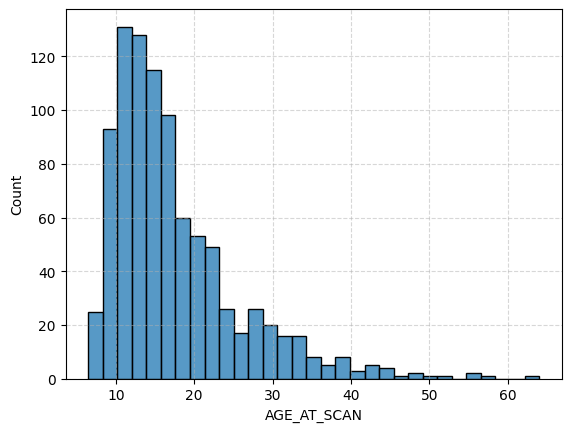

In [7]:
sns.histplot(y)

## Features distributions

In [7]:
sns.displot(
    data=df.melt(),
    x="value",
    col="variable",
    facet_kws={"sharey":False, "sharex":False},
    common_bins=False,
    col_wrap=5
)

plt.savefig("imgs/all_distributions.png")
plt.close()

## Descriptive statistics

In [8]:
statistics = ["max", "min", "mean", "std", "skew", "kurtosis"]
df_stats = df.apply(statistics).T
df_stats["varcoeff"] = df_stats["std"] / df_stats["mean"]
df_stats["range"] = (df_stats["max"] - df_stats["min"]) / df_stats["mean"]

quantile_75 = df.quantile(0.75)
quantile_25 = df.quantile(0.25)

df_stats["IQR_range"] = (quantile_75 - quantile_25) / (quantile_75 + quantile_25)
df_stats_long = df_stats.melt(var_name="statistic")

In [9]:
df_stats_long.sample(5)

statistic         value
1192      mean      0.551691
2964     range      1.193843
1251      mean      0.054645
1744      skew      1.011850
818        min  25004.800000

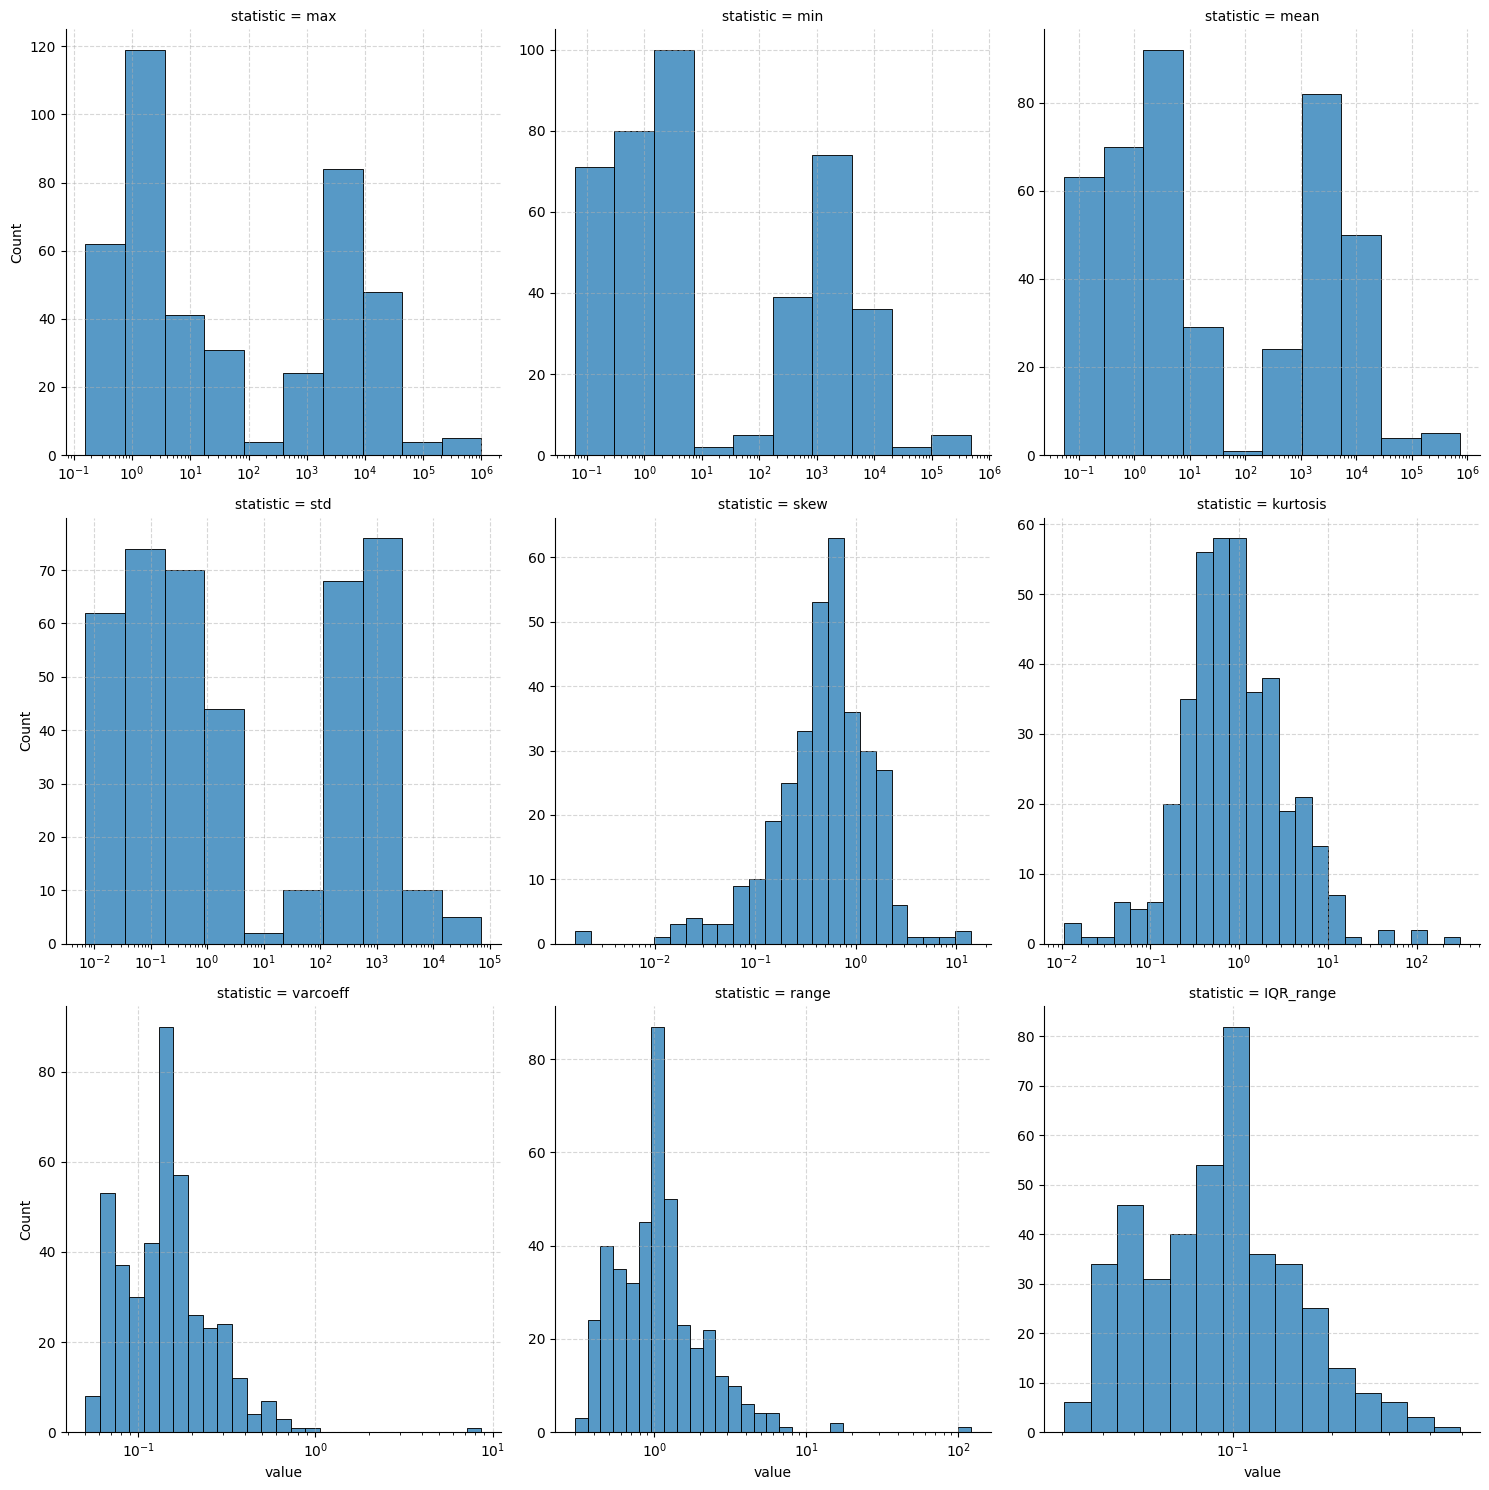

In [10]:
sns.displot(
    data=df_stats_long,
    x="value",
    col="statistic",
    facet_kws={"sharey":False, "sharex":False},
    common_bins=False,
    col_wrap=3,
    log_scale=True

)


## Outliers 

In [11]:
col_high_kurt = df_stats["kurtosis"].sort_values(ascending=False).head(30).index

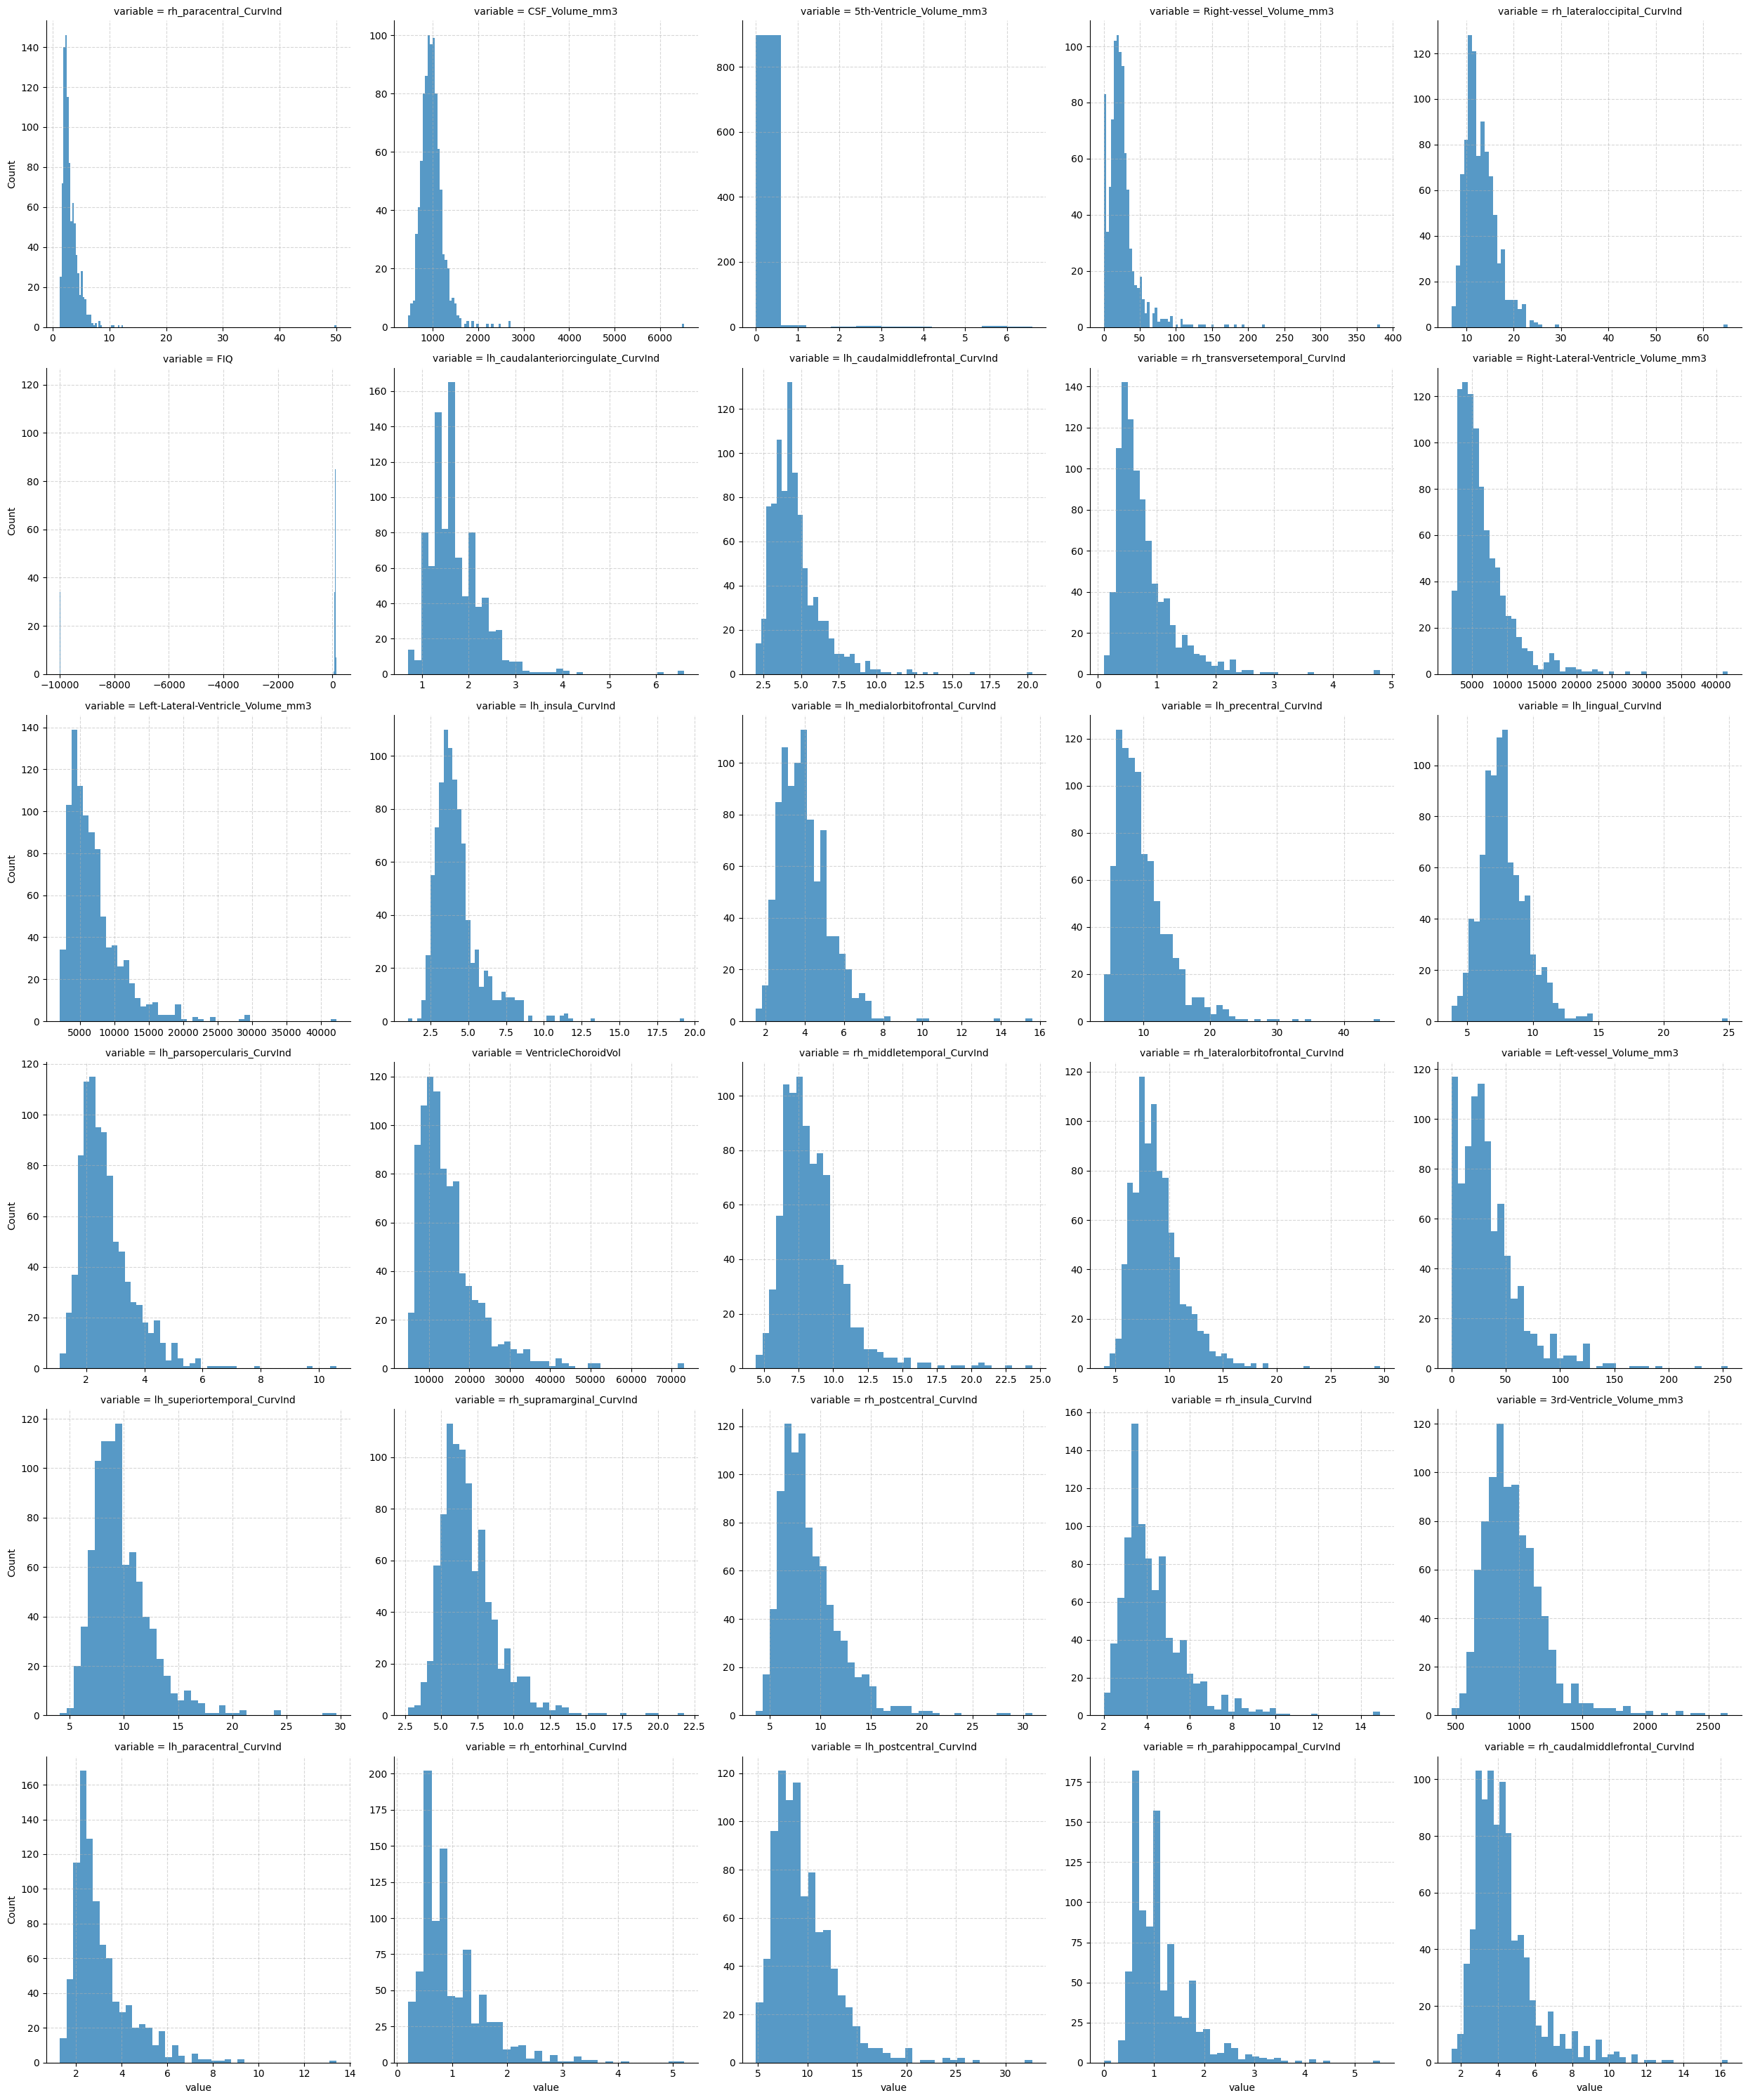

In [12]:
sns.displot(
    data=df[col_high_kurt].melt(),
    x="value",
    col="variable",
    facet_kws={"sharey":False, "sharex":False},
    common_bins=False,
    col_wrap=5
)

## Correlation

<Axes: >

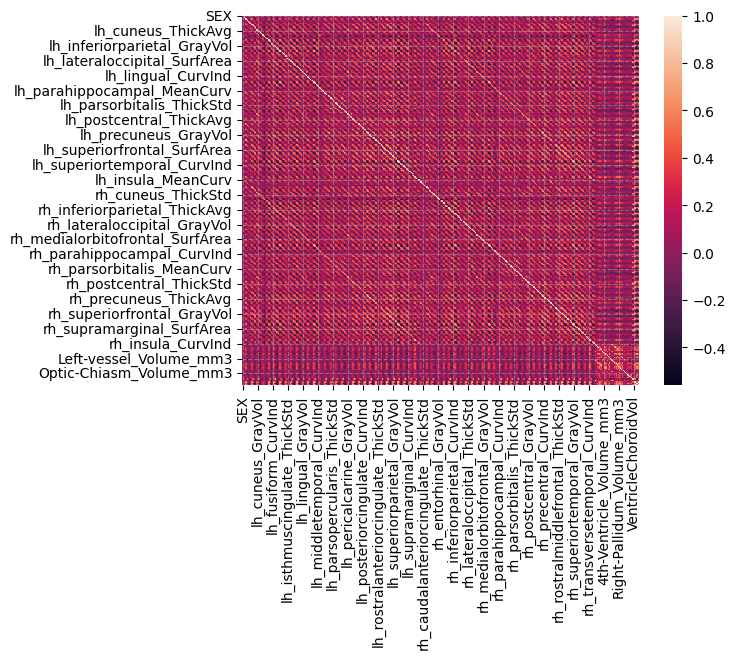

In [13]:
df_corr = df.corr().fillna(0)
sns.heatmap(df_corr)

Text(0.5, 0, 'pearson correlation coefficient')

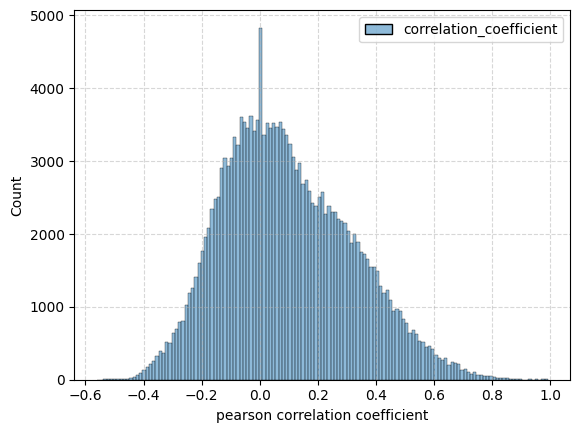

In [14]:
np.fill_diagonal(df_corr.values, 0)
bivariate_corr = df_corr.unstack().rename("correlation_coefficient").to_frame()
sns.histplot(bivariate_corr)
plt.xlabel("pearson correlation coefficient")

In [15]:
df_corr[df_corr < 0.70] = 0
corr_graph = nx.from_pandas_adjacency(df_corr)
connected_components = list(nx.connected_components(corr_graph))

In [16]:
high_corr_components = [component for component in connected_components if len(component) > 3]

print("Clusters of features with high correlation:", len(high_corr_components))


Clusters of features with high correlation: 10


## Correlation with the target

Text(0.5, 0, 'Correlation with the target')

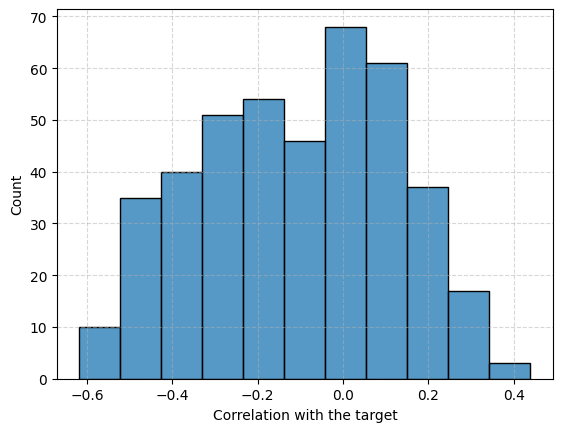

In [17]:
df_with_target = pd.concat([df, y], axis=1)
corr_with_target = df_with_target.corr().fillna(0)["AGE_AT_SCAN"][:-1]

sns.histplot(corr_with_target)
plt.xlabel("Correlation with the target")

/Users/spinap/Library/Caches/pypoetry/virtualenvs/neuroimage-q89akeZ7-py3.9/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/Users/spinap/Library/Caches/pypoetry/virtualenvs/neuroimage-q89akeZ7-py3.9/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


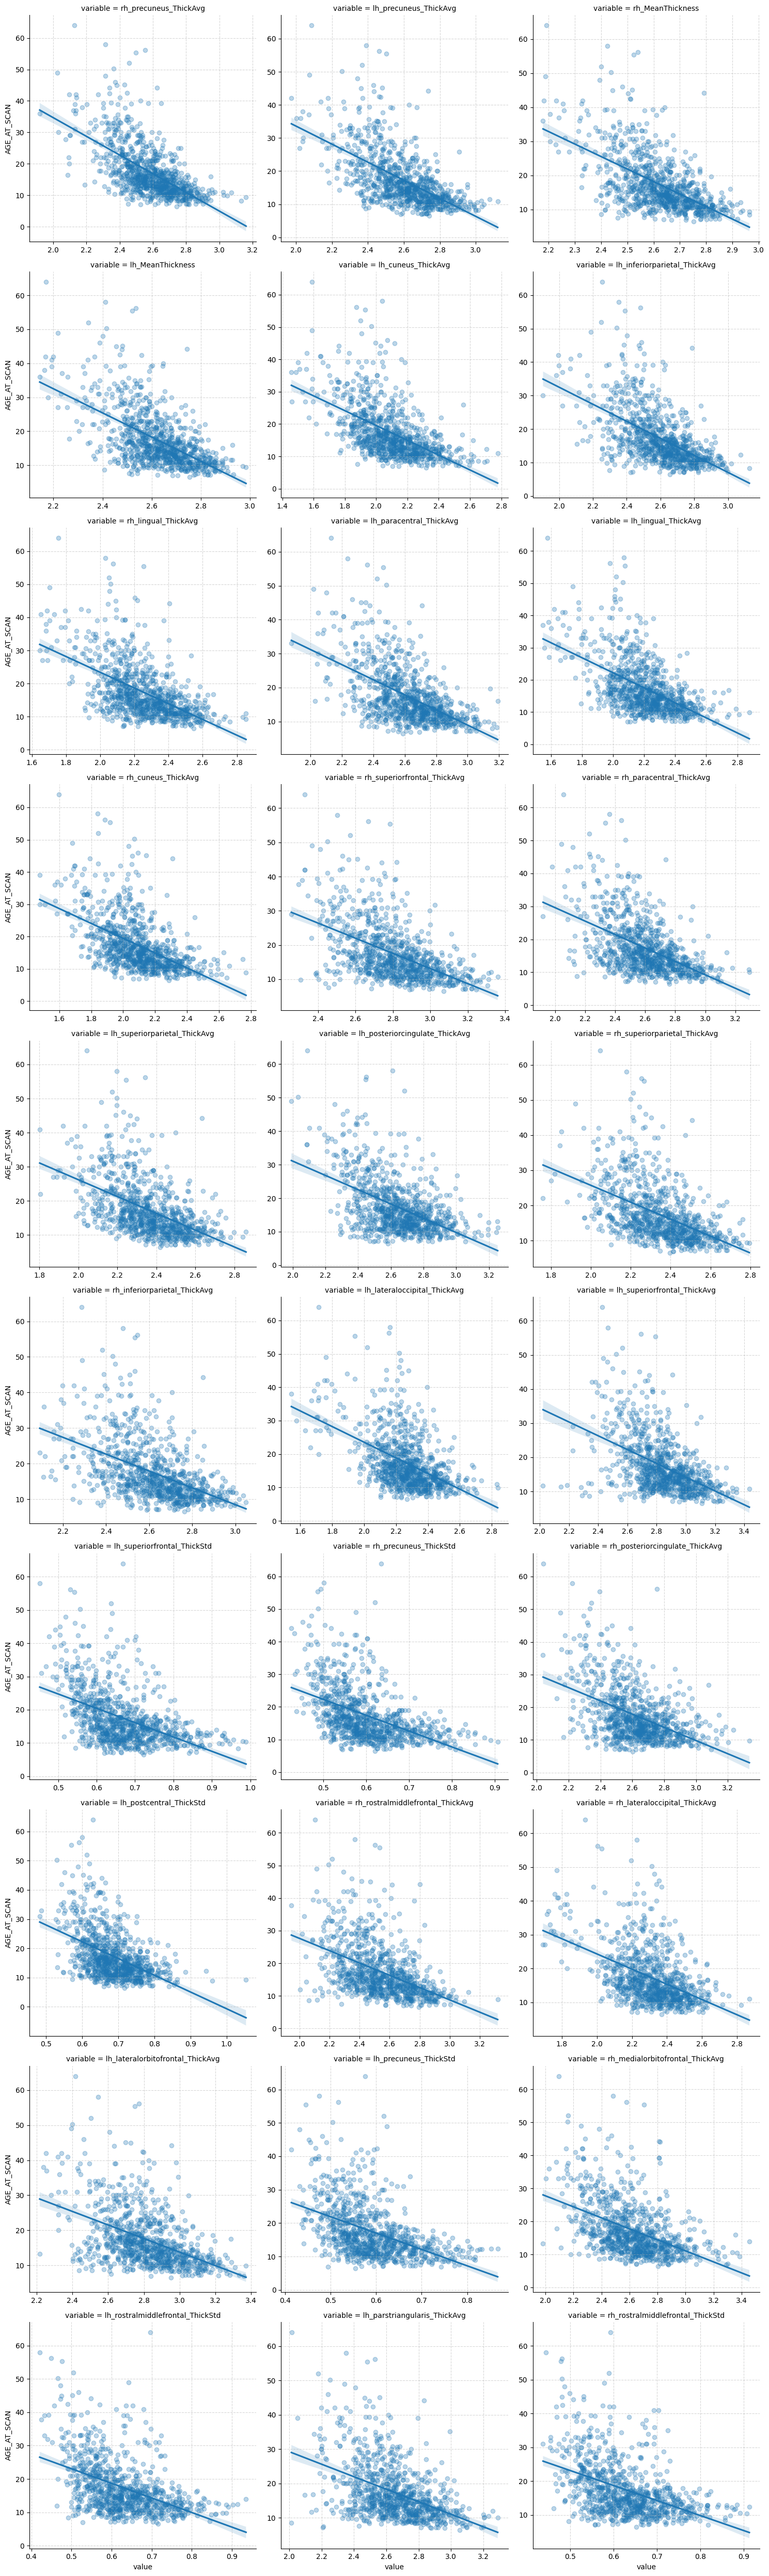

In [18]:
top_corr_features = (
    np.abs(corr_with_target)
    .sort_values(ascending=False)
    .head(30)
    .index
)

df_long=(
    pd.concat((df[top_corr_features], y), axis=1)
    .melt(id_vars="AGE_AT_SCAN")
)

sns.lmplot(
    data=df_long,
    x="value",
    y="AGE_AT_SCAN",
    col="variable",
    col_wrap=3,
    sharex=False,
    sharey=False, 
    scatter_kws={"alpha": 0.3}
)

## Normalization

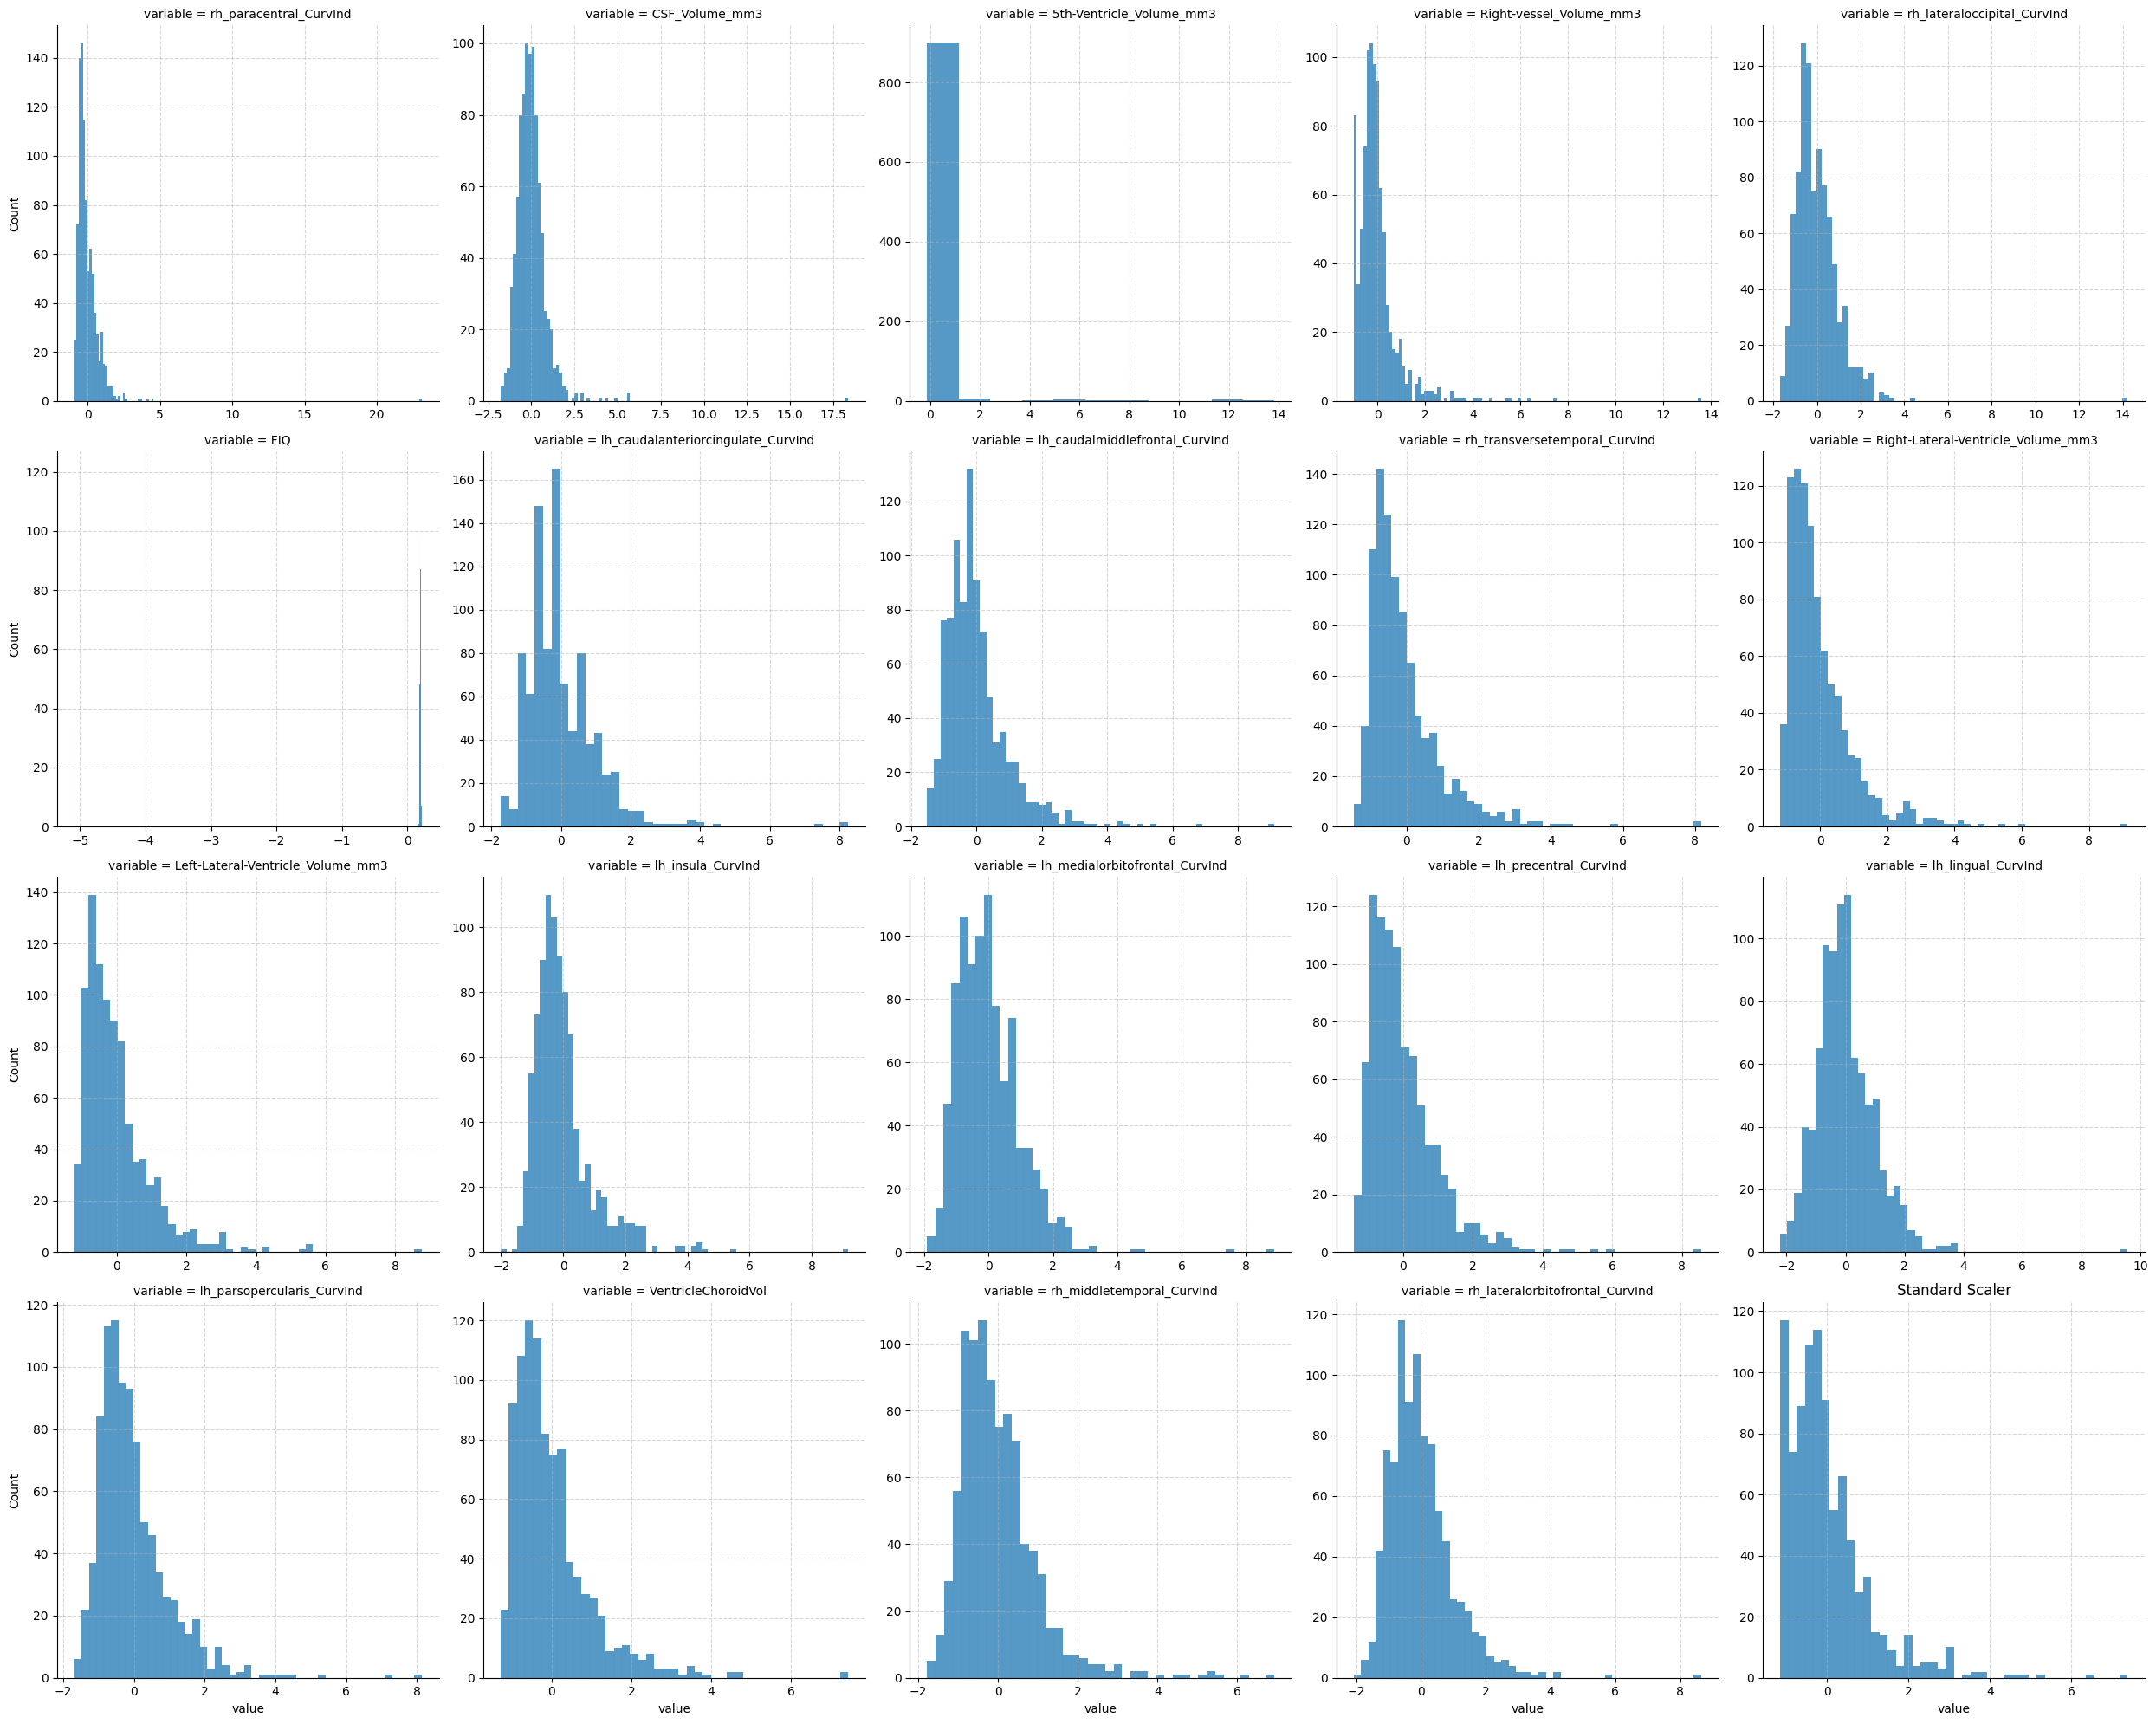

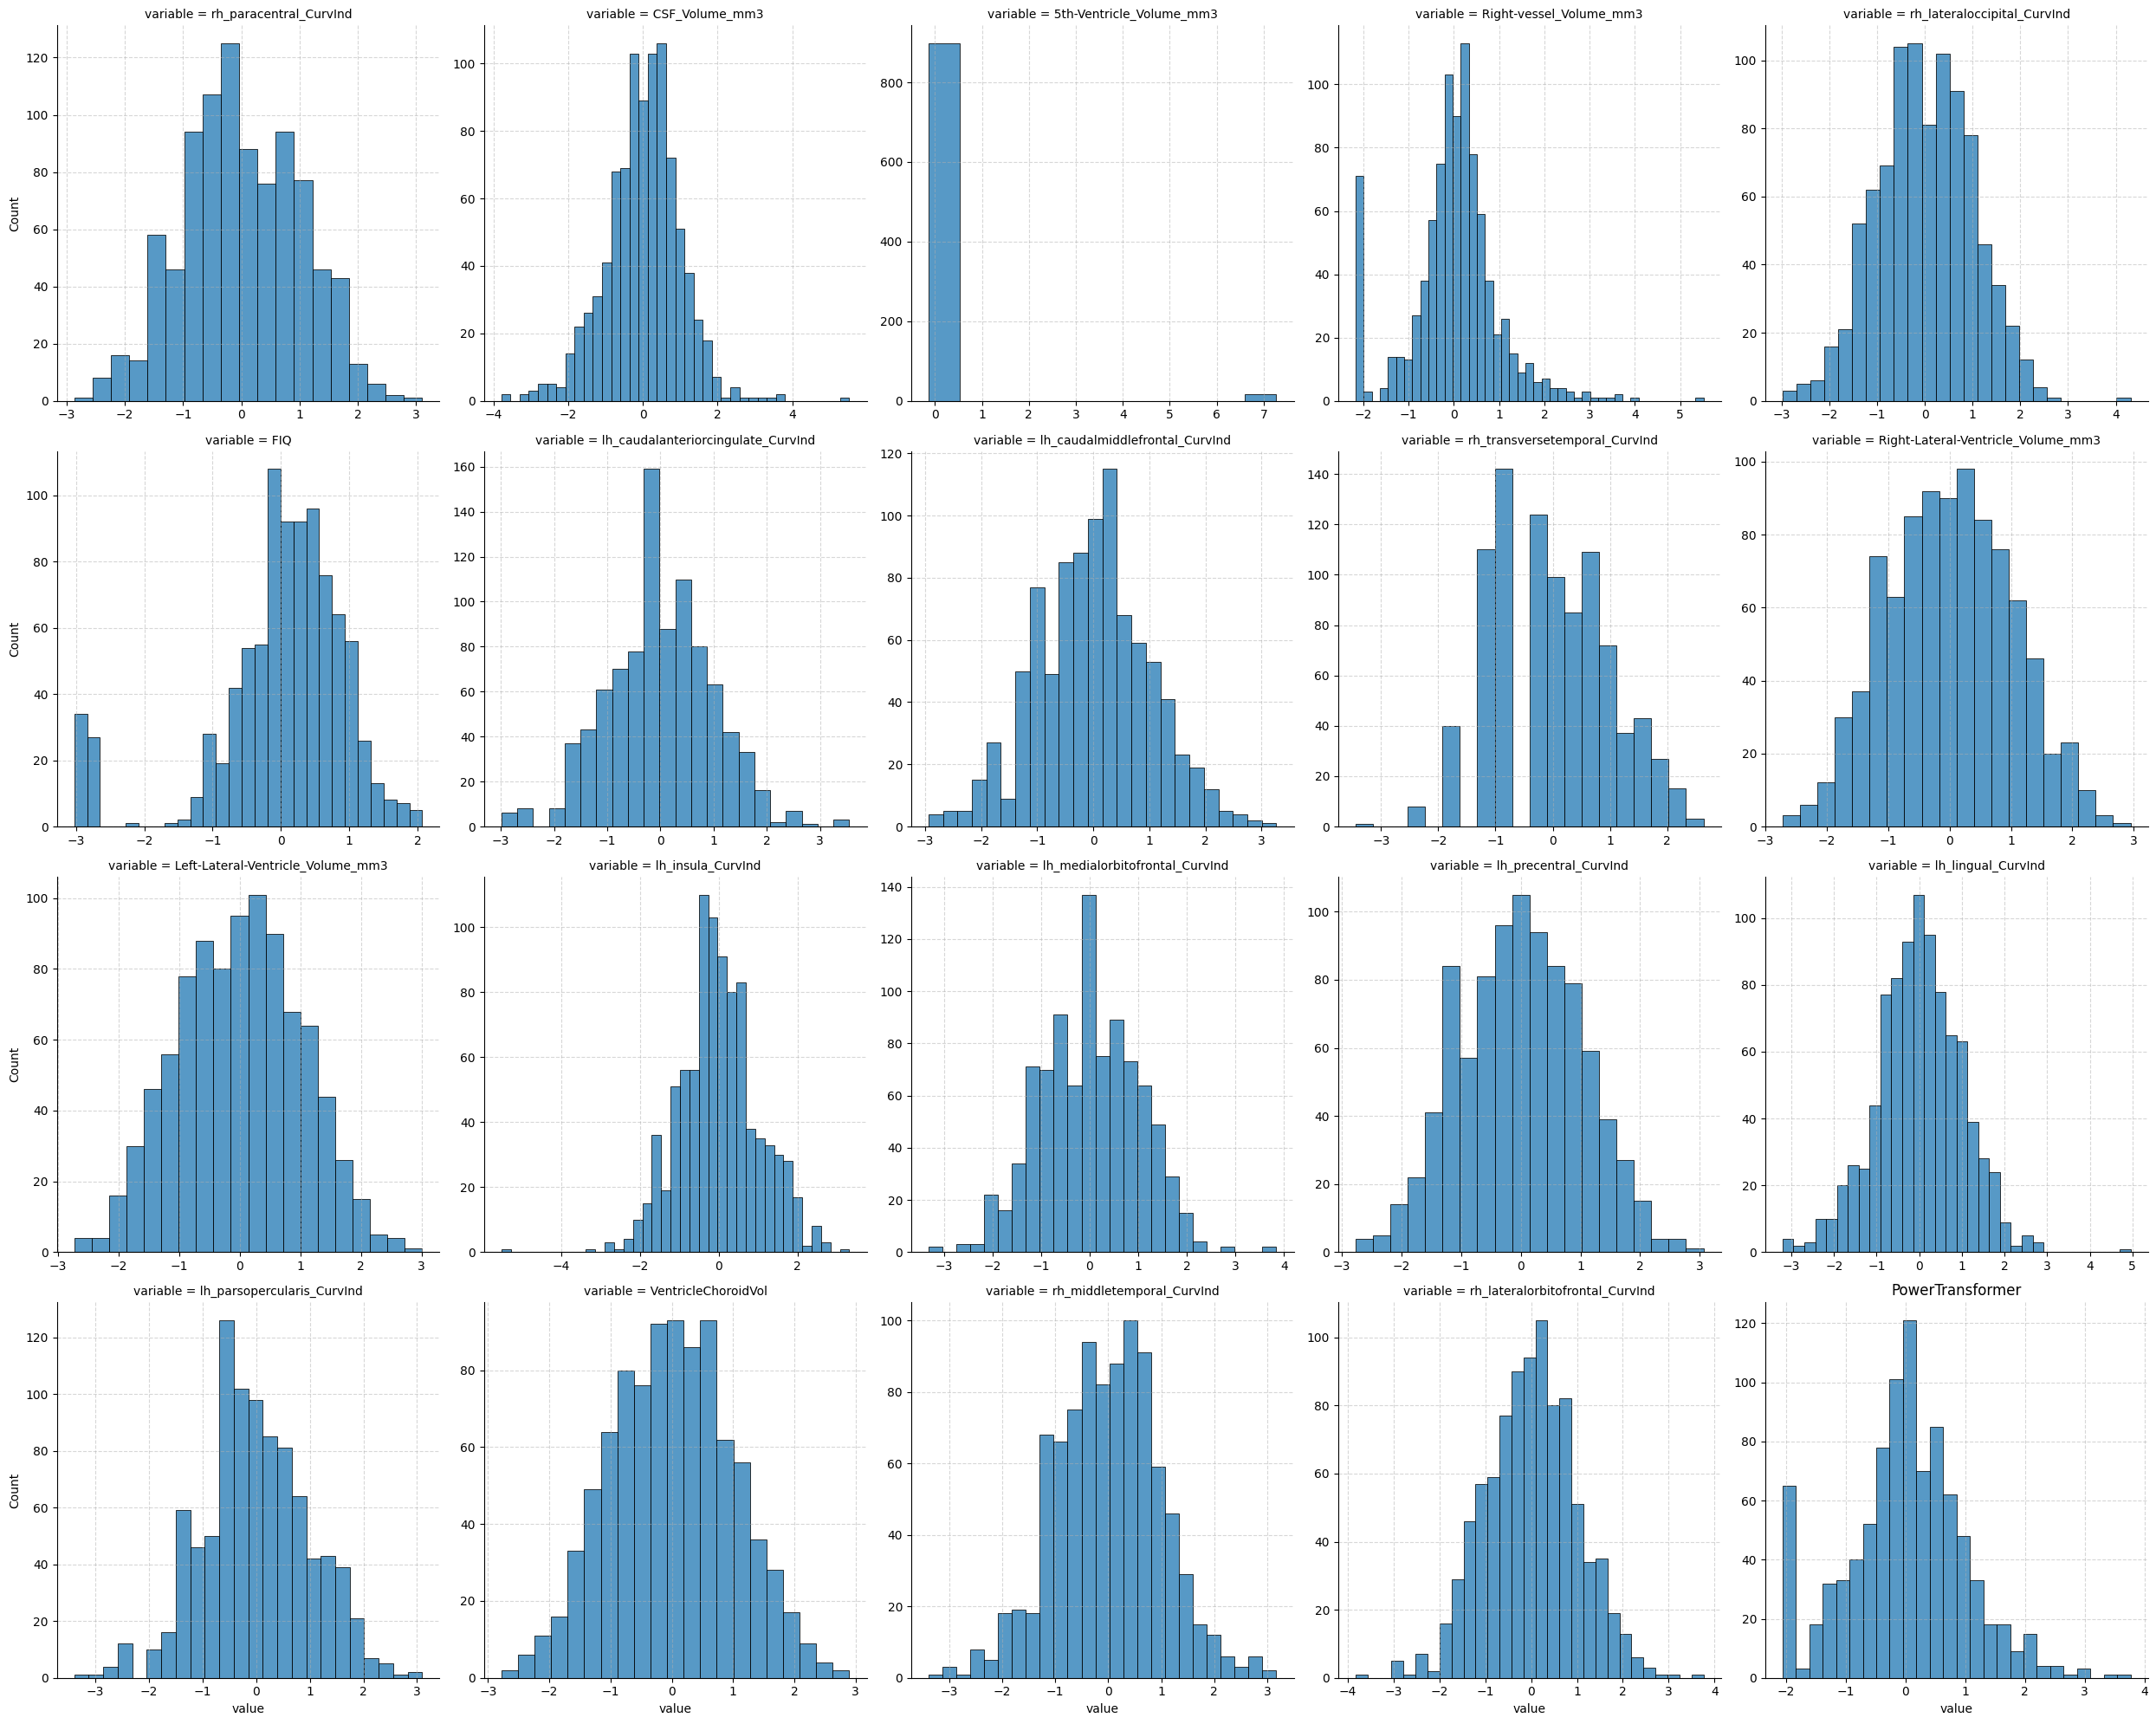

In [20]:
from sklearn.preprocessing import StandardScaler, PowerTransformer

high_variance_col = df.kurtosis().sort_values(ascending=False).head(20).index
scalers = [StandardScaler(), PowerTransformer()]

names = ["Standard Scaler", "PowerTransformer"]

for scaler, name in zip(scalers, names):
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    g = sns.displot(
        data=scaled_df[high_variance_col].melt(),
        x="value",
        col="variable",
        facet_kws={"sharey":False, "sharex":False},
        common_bins=False,
        col_wrap=5
    )
    plt.title(name)
        

## PCA

Text(0, 0.5, 'Explained variance')

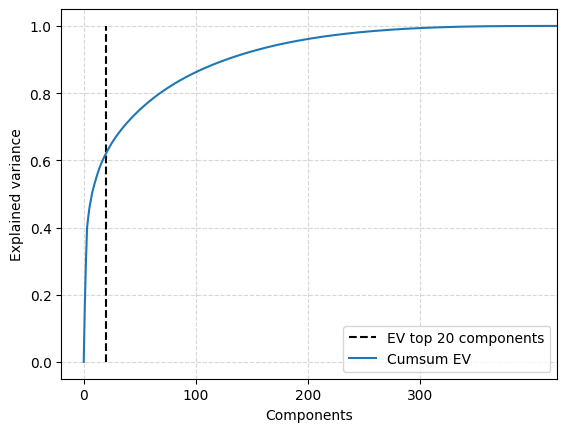

In [33]:
# normalize the data
pca = PCA().fit(scaled_df)

plt.vlines(20, 0, 1, ls="--", color="black", label=r"EV top 20 components")
plt.plot(np.concatenate([[0.0], pca.explained_variance_ratio_.cumsum()]), label="Cumsum EV")
plt.legend(loc="lower right")

plt.xticks(range(0 , 400, 100))
plt.xlim(-20, df.shape[1])
plt.xlabel("Components")
plt.ylabel("Explained variance")